In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.lax import scan
from scipy.linalg import solve_discrete_are, norm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum, plot_optimization_results
from jax_filters import apply_filtering_fixed_linear, kalman_filter_process, filter_step_linear
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix

key = random.PRNGKey(3)

# System dimensions
n = 40  # System dimension
num_steps = 1000 # number of steps
J0 = 0 # burn in period
N = 10 # Monte Carlo samples

def create_stable_matrix(n, key): # Generate a symmetric random matrix
    A = random.normal(key, (n, n))
    A = (A + A.T) / 2
    eigenvalues, eigenvectors = eigh(A)
    scaled_eigenvalues = eigenvalues / (jnp.abs(eigenvalues).max() + 0.1)  # Scale eigenvalues to ensure stability (spectral radius < 1)
    A_stable = eigenvectors @ jnp.diag(scaled_eigenvalues) @ eigenvectors.T
    return A_stable

# Model parameters
C0 = jnp.eye(n) * 1.0   # Initial state covariance matrix (P)
q = random.normal(key, (n, n))/5
Q = q@q.T + jnp.eye(n)*0.1  # Process noise covariance matrix (Sigma in Julia code)
H = jnp.eye(n)[::2] #partial observation
m0 = jnp.ones((n,))
R = jnp.eye(H.shape[0])  # R now becomes 20x20 for partial H 20*40
inv_R = inv(R)
M = create_stable_matrix(n,key)    # State transition matrix (A)
observation_interval = 1

# State initialization
vd0 = m0 + random.multivariate_normal(key, jnp.zeros(n), C0)
key, _ = random.split(key)

def state_transition_function(x):
    return jnp.dot(M, x)

def jacobian_function(x):
    return M

jac_func = Partial(jacobian_function)
A_step = Partial(state_transition_function)

In [2]:
observations, true_states = generate_true_states(key, num_steps, n, vd0, H, Q, R, A_step, observation_interval)

In [10]:
@partial(jit, static_argnums=(3,10))
def var_cost(K, m0, C0, n, M, H, Q, R, y, key, N, num_steps, J0):
    m_preds, C_preds, m_updates, C_updates = apply_filtering_fixed_linear(m0, C0, y, K, n, M, H, Q, R)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(m_preds, C_preds, m_updates, C_updates, n, A_step, Q, key)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, m_updates, C_updates), y, H, R, num_steps, J0)  
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    return cost


In [11]:

@partial(jit, static_argnums=(3))
def var_cost_single_step(K, m0, C0, n, Q, H, R, y_curr, key, J, J0):
    _, (m_pred, C_pred, m_update, C_update)  =  filter_step_linear((m0,C0,m0,C0), y_curr, K, n, M, H, Q, R)
    log_likelihood_val = log_likelihood(m_update[jnp.newaxis, :], y_curr[jnp.newaxis, :], H, R, J=1, J0=J0)
    kl_divergence = KL_gaussian(n, m_update, C_update, m_pred, C_pred)
    # Combine the KL divergence and the negative log-likelihood to form the cost
    cost = kl_divergence - log_likelihood_val
    return cost


In [12]:
P = solve_discrete_are(M.T, H.T, Q, R)
# Compute steady-state Kalman gain K
K_steady = P @ H.T @ jnp.linalg.inv(H @ P @ H.T + R)

In [13]:
base_m, base_C, base_K  = kalman_filter_process(A_step, jac_func, m0, C0, observations, H, Q, R)

In [14]:
# true_div1 = []
# prediction_errors1 = [] 
# norms1 = []
# Ks1 = []

# live = True

# # Define the gradient of the cost function
# var_cost_single_grad = grad(var_cost_single_step, argnums = 0)

# # Initial guess for K and optimization parameters
# K_opt = jnp.zeros((40, 20))
# for i in range(0, K_opt.shape[1]):
#     K_opt = K_opt.at[i*2, i].set(1)
    
# alpha = 1e-5

# for i in tqdm(range(num_steps)):
#     key, _ = random.split(key)
#     y_curr = observations[i] 
#     # Update the gradient and Kalman gain
#     for j in range(100):
#         grad_K = var_cost_single_grad(K_opt, m0, C0, n, Q, H, R, y_curr, key, num_steps, J0)
#         K_opt -= alpha * grad_K
#     Ks1.append(K_opt)
#     norms1.append(jnp.linalg.norm(K_opt - K_steady)) 
#     (m_update, C_update), _ = filter_step_linear((m0, C0), y_curr, K_opt, n, M, H, Q, R)
#     prediction_error = jnp.square(m_update - true_states[i]).mean()  # Assuming true_states[i] is available
#     prediction_errors1.append(prediction_error)
#     true_div1.append(KL_gaussian(n, m_update, C_update, base_m[i], base_C[i]))
#     # Prepare for the next step
#     m0, C0 = m_update, C_update



In [ ]:
# import os
# from jax_vi import plot_optimization_results, plot_k_matrices

# subfolder_name = 'linear_results'
# os.makedirs(subfolder_name, exist_ok=True)  # Create directory if it doesn't exist
# file_base_name = "linear_gain_partial"

# if live:
#     file_base_name += "_online"
# file_name = file_base_name + ".pdf"
# file_path = os.path.join(subfolder_name, file_name)

# plot_optimization_results(norms1, prediction_errors1, true_div1, len(norms1), file_path)

# file_base_name = "linear_gain_matrices_partial"
# if live:
#     file_base_name += "_online"
# file_name = file_base_name + ".pdf"
# file_path = os.path.join(subfolder_name, file_name)
# plot_k_matrices(K_steady, K_opt, file_path)


In [14]:
# last_200_errors_online = jnp.array(prediction_errors1[-200:])
# print("Mean error for last 200 timesteps", jnp.mean(last_200_errors_online))

Mean error for last 200 timesteps 1.1088294


In [19]:
import pickle
K_opt = jnp.zeros((40, 20))
for i in range(0, K_opt.shape[1]):
    K_opt = K_opt.at[i*2, i].set(1)

true_div = []
prediction_errors = [] 
norms = []
last_200_errors = []    # Errors for the last 200 timesteps
Ks = []
live = False


t = 0  
n_iters = 500
var_cost_grad = grad(var_cost, argnums=0)
# Initial guess for K and optimization parameters
key, _ = random.split(key)
alpha = 1e-5

for i in tqdm(range(n_iters)):
    key, _ = random.split(key)
    # Update the gradient and Kalman gain
    grad_K = var_cost_grad(K_opt, m0, C0, n, M, H, Q, R, observations, key, N, num_steps, J0)
    K_opt -= alpha * grad_K
    Ks.append(K_opt)
    # Apply filtering with the newly optimized K to generate state predictions
    _, _, predicted_states, covariances = apply_filtering_fixed_linear(m0, C0, observations, K_opt, n, M, H, Q, R)
    prediction_error = jnp.mean(jnp.mean((predicted_states - true_states)**2, axis=1))#jnpl.norm(predicted_states - true_states) ** 2 / len(true_states)
    prediction_errors.append(prediction_error)
    last_200_prediction_error = jnp.mean((predicted_states[-200:] - true_states[-200:])**2)
    last_200_errors.append(last_200_prediction_error)
    norms.append(norm(K_opt - K_steady))
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, predicted_states[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t
    
    true_div.append(total_kl_divergence / num_steps)
    #print(total_kl_divergence / num_steps)


data = {
    'norms': norms,
    'prediction_errors': prediction_errors,
    'true_div': true_div,
    'n_iters': n_iters,
    'K_steady': K_steady,
    'K_opt': K_opt
}
with open('fixed_linear_partial', 'wb') as f:
    pickle.dump(data, f)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
# #print("Mean error for last 200 timesteps (at convergence)", jnp.mean(jnp.array(last_200_errors[-10:])))
# classic_kf_prediction_errors = jnp.mean(jnp.square(base_m - true_states), axis=1)

# print("Classic KF Prediction MSE (last 200 steps):", jnp.mean(classic_kf_prediction_errors[-200:]))

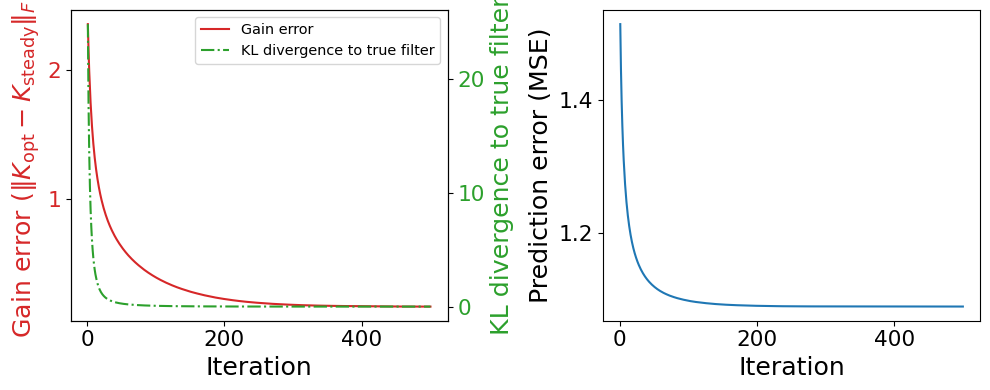

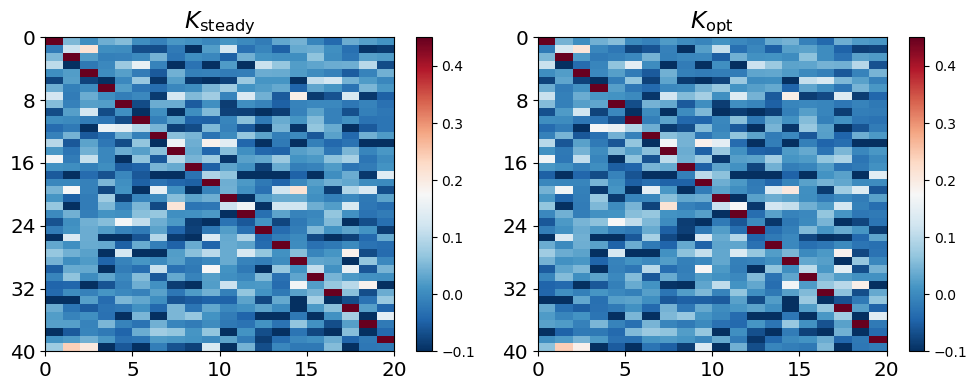

In [2]:
import pickle
with open('fixed_linear_partial', 'rb') as f:
    data = pickle.load(f)

online = False
norms = data['norms']
prediction_errors = data['prediction_errors']
true_div = data['true_div']
n_iters = data['n_iters']
K_steady = data['K_steady']
K_opt = data['K_opt']
import os
from jax_vi import plot_optimization_results, plot_k_matrices

subfolder_name = 'linear_results'
file_base_name = "linear_gain_partial"

if online:
    n_iters = num_steps
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)

plot_optimization_results(norms, prediction_errors, true_div, n_iters, file_path, scaling=1.3, max_n_locator=3)

file_base_name = "linear_gain_matrices_partial"
if online:
    file_base_name += "_online"
file_name = file_base_name + ".pdf"
file_path = os.path.join(subfolder_name, file_name)
plot_k_matrices(K_steady, K_opt, file_path, scaling=1.2, max_n_locator=5)